In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import sys
sys.path.append('..')

import logging
from src.utils import setup_logging
setup_logging(console=True, file=False, debug=True)
logger = logging.getLogger(__name__)

[INFO]: Logging setup completed at 09-08-2024-121712        (utils.py:62 [12:17:12])


['The night will start off chilly with temperatures around 7 degrees, gradually dropping to around 6.5 degrees by early morning, but warming up to a comfortable 17.9 degrees by mid-afternoon. Expect a cooler evening as temperatures drop back to 6.7 degrees by midnight.']


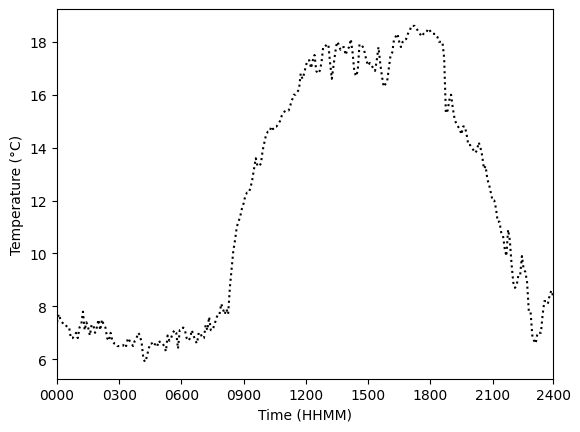

In [3]:
import pandas as pd
from data.tempdata import TempData
import matplotlib.pyplot as plt
# Load the data
data_path = '../data/data_with_desc.csv'
data = pd.read_csv(data_path, header=None)
data_test = TempData(data=data, max_num_context=10, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

temporary_batch_size = 1
batch = data_test.generate_batch(batch_size=temporary_batch_size, split='val', return_knowledge=True)

fig = plt.figure()
print(batch.knowledge)
for i in range(temporary_batch_size):
    x_target = batch.x_target[i].flatten()
    y_target = batch.y_target[i].flatten()
    plt.plot(x_target.numpy(), y_target.numpy(), 'k:')
# for i in range(temporary_batch_size):
#     x_context = batch.x_context[i].flatten()
#     y_context = batch.y_context[i].flatten()
#     plt.scatter(x_context.numpy(), y_context.numpy())
plt.xlim(-2, 2)
    # Formatting the x-axis to display time in "HHMM" format
plt.xticks(list(x_target[::36])+ [2.0], labels=["0000", "0300", "0600", "0900", "1200", "1500", "1800", "2100", "2400"])

# Label axes
plt.xlabel('Time (HHMM)')
plt.ylabel('Temperature (°C)')

# fig.savefig('../figures/temperature_sample1', dpi=300)
plt.show()

In [11]:
from src.plot import plot_predictive
from src.informed_np import InformedNeuralProcess
from tqdm import tqdm
# from src.loss import ELBOLoss
from src.loss import ELBOLoss
from src.train import train
from types import SimpleNamespace

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logging.info(f'Using DEVICE: {DEVICE}')

x_dim = 1
y_dim = 1
determ_dim = 128  # Dimension of representation of context points
latent_dim = 128  # Dimension of sampled latent variable
hidden_dim = 128  # Dimension of hidden layers in encoder and decoder

data_path = '../data/data_with_desc.csv'
data = pd.read_csv(data_path, header=None)
data = TempData(data=data , max_num_context=10, device=DEVICE)

args = dict(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    determ_dim=determ_dim,
    knowledge_dim=128,
    mlps_activation=nn.GELU(),
    x_proj_dim=1,
    n_h_layers_x_proj=0,
    n_h_layers_decoder=4,
    n_h_layers_latent_xy_encoder=3,
    n_h_layers_film_latent_encoder=3,
    path='latent',
    train_num_z_samples=4,
    test_num_z_samples=32,
    use_bias=True,
    use_context_in_target=True, # TODO investigate
    use_latent_self_attn=True,
    # use_determ_self_attn=True,
    # use_determ_cross_attn=True,
    # use_knowledge=USE_KNOWLEDGE,
    knowledge_dropout=0.3,
    roberta_return_cls=True,
    tune_llm_layer_norms=True,
    freeze_llm=True,
    knowledge_projection_n_h_layers=0,
    knowledge_aggregation_method='FiLM+MLP',
    device='cuda',
    beta=1.0
)
assert "use_knowledge" not in args

[INFO]: Using DEVICE: cuda:0        (614822831.py:10 [12:22:19])


[INFO]: USE_KNOWLEDGE: True        (1860173446.py:2 [12:22:33])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [12:22:33])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [12:22:33])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [12:22:33])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [12:22:33])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [12:22:33])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [12:22:55])
[DEBUG]: Allowing LLM LayerNorm parameters 

iter 1: Val. Loss (NLL): 41750.319732666016


[INFO]: Saving new best val loss model at iter 1        (train.py:121 [12:23:10])


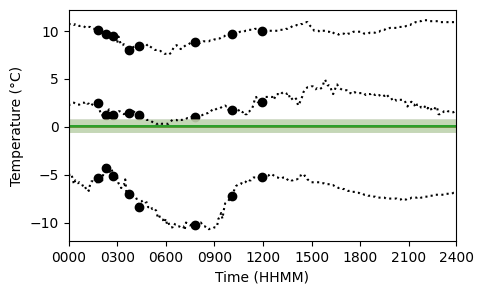

iter 250: avg. Train Loss = 1860.36173046875


[INFO]: Removing model at path '../exp/_iter1.pt'        (train.py:128 [12:23:45])


iter 250: Val. Loss (NLL): 993.254246711731


[INFO]: Saving new best val loss model at iter 250 to path ../exp/_iter250.pt        (train.py:133 [12:23:46])


iter 500: avg. Train Loss = 981.2477224121094


[INFO]: Removing model at path '../exp/_iter250.pt'        (train.py:128 [12:24:20])


iter 500: Val. Loss (NLL): 938.8100633621216


[INFO]: Saving new best val loss model at iter 500 to path ../exp/_iter500.pt        (train.py:133 [12:24:21])


iter 750: avg. Train Loss = 940.7675463867188


[INFO]: Removing model at path '../exp/_iter500.pt'        (train.py:128 [12:24:56])


iter 750: Val. Loss (NLL): 827.2004709243774


[INFO]: Saving new best val loss model at iter 750 to path ../exp/_iter750.pt        (train.py:133 [12:24:57])


iter 1000: avg. Train Loss = 665.4645034179688


[INFO]: Removing model at path '../exp/_iter750.pt'        (train.py:128 [12:25:32])


iter 1000: Val. Loss (NLL): 617.4513440132141


[INFO]: Saving new best val loss model at iter 1000 to path ../exp/_iter1000.pt        (train.py:133 [12:25:33])


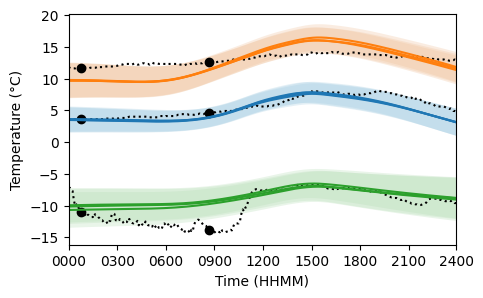

iter 1250: avg. Train Loss = 634.8767032470703


[INFO]: Removing model at path '../exp/_iter1000.pt'        (train.py:128 [12:26:09])


iter 1250: Val. Loss (NLL): 613.692018032074


[INFO]: Saving new best val loss model at iter 1250 to path ../exp/_iter1250.pt        (train.py:133 [12:26:10])


iter 1500: avg. Train Loss = 621.3101281738282


[INFO]: Removing model at path '../exp/_iter1250.pt'        (train.py:128 [12:26:45])


iter 1500: Val. Loss (NLL): 566.3290419578552


[INFO]: Saving new best val loss model at iter 1500 to path ../exp/_iter1500.pt        (train.py:133 [12:26:46])


iter 1750: avg. Train Loss = 558.1776901855469


[INFO]: Removing model at path '../exp/_iter1500.pt'        (train.py:128 [12:27:21])


iter 1750: Val. Loss (NLL): 560.0329256057739


[INFO]: Saving new best val loss model at iter 1750 to path ../exp/_iter1750.pt        (train.py:133 [12:27:22])


iter 2000: avg. Train Loss = 523.3215084228516


[INFO]: Removing model at path '../exp/_iter1750.pt'        (train.py:128 [12:27:57])


iter 2000: Val. Loss (NLL): 526.2352302074432


[INFO]: Saving new best val loss model at iter 2000 to path ../exp/_iter2000.pt        (train.py:133 [12:27:58])


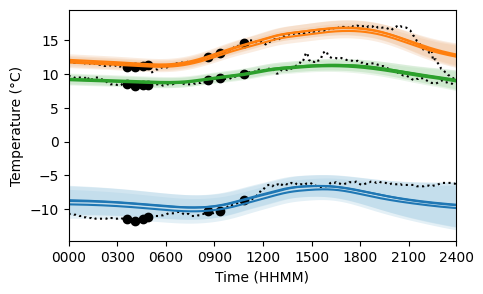

iter 2250: avg. Train Loss = 522.5012619628907
iter 2250: Val. Loss (NLL): 556.9248666763306
iter 2500: avg. Train Loss = 490.74489318847657
iter 2500: Val. Loss (NLL): 646.5746250152588
iter 2750: avg. Train Loss = 506.4836145019531
iter 2750: Val. Loss (NLL): 535.5987575054169
iter 3000: avg. Train Loss = 473.33652319335937
iter 3000: Val. Loss (NLL): 532.9954779148102


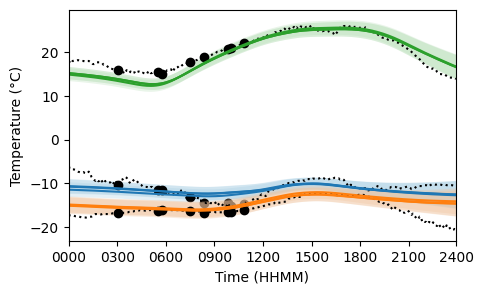

iter 3250: avg. Train Loss = 497.44826208496096
iter 3250: Val. Loss (NLL): 532.4414386749268


ValueError: x and y must have same first dimension, but have shapes (3249,) and (3250,)

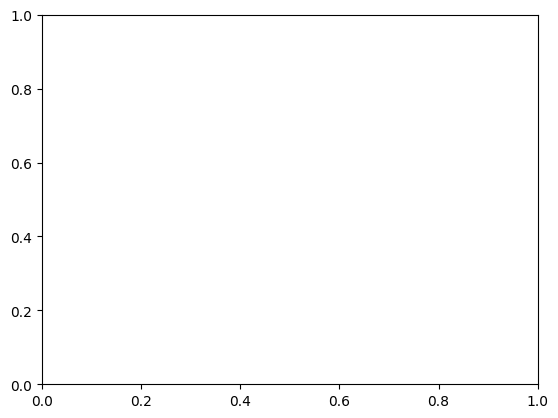

In [12]:
USE_KNOWLEDGE = True
logging.info(f'USE_KNOWLEDGE: {USE_KNOWLEDGE}')#

model = InformedNeuralProcess(
    **args,
    use_knowledge=USE_KNOWLEDGE
).to(DEVICE)

logging.info(model)
logging.info(f'Number of model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

logging.info(f'Using optimiser Adam')
loss_function = ELBOLoss(beta=1, reduction='mean')

LEARNING_RATE = 1e-3
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

AVG_LOSS_PRINT_INTERVAL = 250
PLOT_SAMPLE_INTERVAL = 1000
MAX_ITERS = 10000

model, best_model_path, optimiser, train_losses, val_losses = train(model=model,
                                                   data=data,
                                                   loss_function=loss_function,
                                                   optimiser=optimiser,
                                                   device=DEVICE,
                                                   use_knowledge=USE_KNOWLEDGE,
                                                   max_iters=MAX_ITERS,
                                                   avg_loss_print_interval=AVG_LOSS_PRINT_INTERVAL,
                                                   plot_sample_interval=PLOT_SAMPLE_INTERVAL)

# NP

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:21:50])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:21:50])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [15:21:50])
[INFO]: InformedNeuralProcess(
  (x_context_encoder): XEncoder(
    (mlp): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=1, out_features=1, bias=True)
      )
    )
  )
  (x_target_encoder): XEncoder(
    (mlp): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=1, out_features=128, bias=True)
      )
    )
  )
  (xy_encoder_latent): XYSetEncoder(
    (phi): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): GELU(approximate='none')
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): GELU(approximate='none')
        (6): Linear(in_

iter 1: Val. Loss (NLL): 32822.59962463379


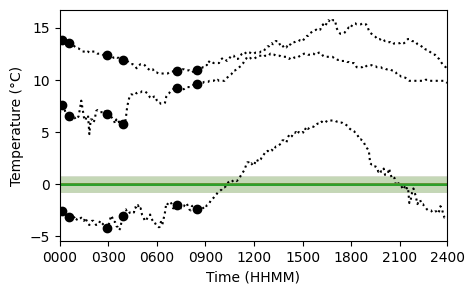

  2%|▏         | 249/10000 [00:05<02:01, 80.57it/s]

iter 250: avg. Train Loss = 1647.5875732421875


[INFO]: Saving new best val loss model at iter 250        (train.py:108 [15:21:57])
  3%|▎         | 258/10000 [00:06<10:24, 15.59it/s]

iter 250: Val. Loss (NLL): 982.2912020683289


  5%|▍         | 496/10000 [00:10<02:32, 62.22it/s]

iter 500: avg. Train Loss = 803.6228227539062


[INFO]: Saving new best val loss model at iter 500        (train.py:108 [15:22:02])
  5%|▌         | 510/10000 [00:12<09:28, 16.70it/s]

iter 500: Val. Loss (NLL): 602.7927374839783


  7%|▋         | 744/10000 [00:16<02:27, 62.80it/s]

iter 750: avg. Train Loss = 520.6355091552734


[INFO]: Saving new best val loss model at iter 750        (train.py:108 [15:22:08])
  8%|▊         | 758/10000 [00:17<09:16, 16.61it/s]

iter 750: Val. Loss (NLL): 601.4977464675903


 10%|▉         | 994/10000 [00:21<02:21, 63.48it/s]

iter 1000: avg. Train Loss = 468.2001668701172


[INFO]: Saving new best val loss model at iter 1000        (train.py:108 [15:22:13])


iter 1000: Val. Loss (NLL): 600.710823059082


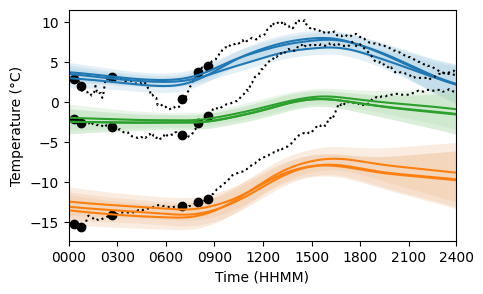

 12%|█▏        | 1245/10000 [00:26<02:16, 64.17it/s]

iter 1250: avg. Train Loss = 453.0859011230469


 13%|█▎        | 1261/10000 [00:28<07:49, 18.61it/s]

iter 1250: Val. Loss (NLL): 648.4533538818359


 15%|█▍        | 1494/10000 [00:32<02:15, 62.67it/s]

iter 1500: avg. Train Loss = 444.3730200195312


[INFO]: Saving new best val loss model at iter 1500        (train.py:108 [15:22:24])
 15%|█▌        | 1508/10000 [00:33<08:34, 16.51it/s]

iter 1500: Val. Loss (NLL): 598.4893553256989


 17%|█▋        | 1743/10000 [00:37<02:10, 63.22it/s]

iter 1750: avg. Train Loss = 435.1134936523438


[INFO]: Saving new best val loss model at iter 1750        (train.py:108 [15:22:29])
 18%|█▊        | 1757/10000 [00:38<08:12, 16.75it/s]

iter 1750: Val. Loss (NLL): 581.926787853241


 20%|█▉        | 1993/10000 [00:42<01:53, 70.84it/s]

iter 2000: avg. Train Loss = 430.13740112304686
iter 2000: Val. Loss (NLL): 592.5381143093109


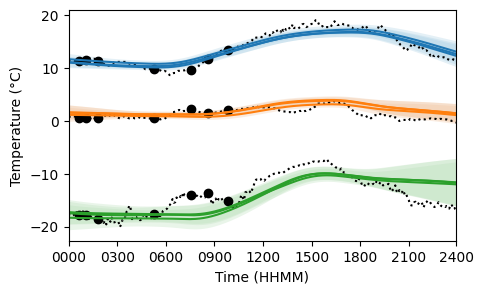

 22%|██▏       | 2246/10000 [00:48<02:03, 62.91it/s]

iter 2250: avg. Train Loss = 430.69873291015625


 23%|██▎       | 2260/10000 [00:49<07:42, 16.75it/s]

iter 2250: Val. Loss (NLL): 664.9643294811249


 25%|██▍       | 2493/10000 [00:53<01:47, 69.85it/s]

iter 2500: avg. Train Loss = 424.7402266845703


[INFO]: Saving new best val loss model at iter 2500        (train.py:108 [15:22:45])
 25%|██▌       | 2507/10000 [00:54<07:01, 17.77it/s]

iter 2500: Val. Loss (NLL): 577.3354895114899


 27%|██▋       | 2749/10000 [00:58<01:32, 78.47it/s]

iter 2750: avg. Train Loss = 419.16203955078123


 28%|██▊       | 2757/10000 [00:59<07:54, 15.25it/s]

iter 2750: Val. Loss (NLL): 621.2053935527802


 30%|██▉       | 2996/10000 [01:03<01:50, 63.49it/s]

iter 3000: avg. Train Loss = 414.25921301269534
iter 3000: Val. Loss (NLL): 621.8282251358032


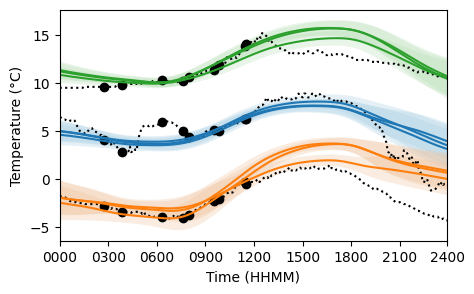

 32%|███▏      | 3245/10000 [01:08<01:25, 78.78it/s]

iter 3250: avg. Train Loss = 400.1200690917969


 33%|███▎      | 3262/10000 [01:09<05:34, 20.15it/s]

iter 3250: Val. Loss (NLL): 668.6106262207031


 35%|███▍      | 3498/10000 [01:12<01:22, 78.68it/s]

iter 3500: avg. Train Loss = 377.2128089599609


 35%|███▌      | 3514/10000 [01:14<05:29, 19.66it/s]

iter 3500: Val. Loss (NLL): 704.4393286705017


 37%|███▋      | 3744/10000 [01:18<01:40, 62.47it/s]

iter 3750: avg. Train Loss = 355.1320389404297


 38%|███▊      | 3758/10000 [01:19<06:13, 16.72it/s]

iter 3750: Val. Loss (NLL): 714.2225487232208


 40%|███▉      | 3994/10000 [01:22<01:23, 71.64it/s]

iter 4000: avg. Train Loss = 347.7858889160156
iter 4000: Val. Loss (NLL): 752.9898681640625


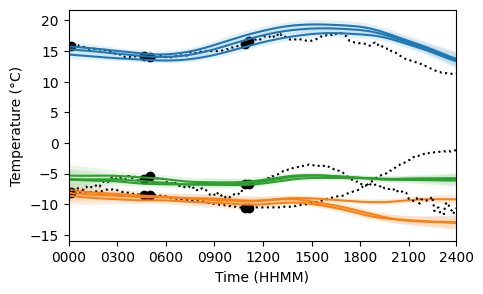

 42%|████▏     | 4249/10000 [01:28<01:33, 61.78it/s]

iter 4250: avg. Train Loss = 353.64407385253907


 43%|████▎     | 4256/10000 [01:29<07:32, 12.70it/s]

iter 4250: Val. Loss (NLL): 727.26886677742


 45%|████▍     | 4494/10000 [01:33<01:26, 63.30it/s]

iter 4500: avg. Train Loss = 335.1035690917969


 45%|████▌     | 4508/10000 [01:35<05:27, 16.79it/s]

iter 4500: Val. Loss (NLL): 812.3781337738037


 47%|████▋     | 4743/10000 [01:39<01:20, 65.33it/s]

iter 4750: avg. Train Loss = 322.5246748046875


 48%|████▊     | 4757/10000 [01:40<05:05, 17.18it/s]

iter 4750: Val. Loss (NLL): 828.5047981739044


 50%|████▉     | 4995/10000 [01:44<01:20, 62.01it/s]

iter 5000: avg. Train Loss = 318.9951097412109
iter 5000: Val. Loss (NLL): 812.6195755004883


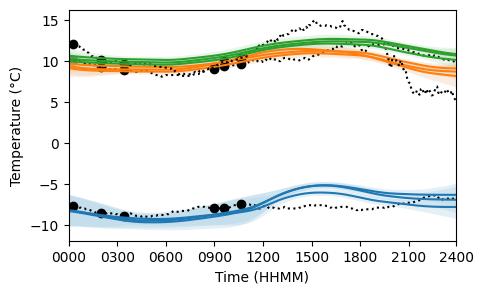

 52%|█████▏    | 5245/10000 [01:49<01:13, 64.93it/s]

iter 5250: avg. Train Loss = 314.32771520996096


 53%|█████▎    | 5259/10000 [01:51<04:41, 16.85it/s]

iter 5250: Val. Loss (NLL): 836.3969883918762


 55%|█████▍    | 5497/10000 [01:55<01:13, 61.36it/s]

iter 5500: avg. Train Loss = 314.90555963134767


 55%|█████▌    | 5511/10000 [01:57<04:30, 16.60it/s]

iter 5500: Val. Loss (NLL): 914.3816184997559


 57%|█████▋    | 5748/10000 [02:00<01:08, 62.03it/s]

iter 5750: avg. Train Loss = 305.09973553466796


 58%|█████▊    | 5762/10000 [02:02<04:12, 16.76it/s]

iter 5750: Val. Loss (NLL): 876.6578011512756


 60%|█████▉    | 5993/10000 [02:06<01:03, 62.78it/s]

iter 6000: avg. Train Loss = 303.5122817993164
iter 6000: Val. Loss (NLL): 810.8716387748718


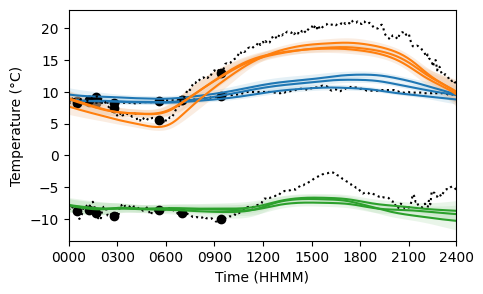

 62%|██████▏   | 6245/10000 [02:11<01:01, 61.44it/s]

iter 6250: avg. Train Loss = 290.34638061523435


 63%|██████▎   | 6259/10000 [02:13<03:44, 16.67it/s]

iter 6250: Val. Loss (NLL): 805.1766180992126


 65%|██████▍   | 6495/10000 [02:17<00:52, 67.01it/s]

iter 6500: avg. Train Loss = 279.0674125366211


 65%|██████▌   | 6509/10000 [02:18<03:21, 17.31it/s]

iter 6500: Val. Loss (NLL): 888.3253841400146


 67%|██████▋   | 6743/10000 [02:22<00:52, 62.62it/s]

iter 6750: avg. Train Loss = 289.7905373535156


 68%|██████▊   | 6757/10000 [02:24<03:14, 16.71it/s]

iter 6750: Val. Loss (NLL): 985.778121471405


 70%|██████▉   | 6995/10000 [02:27<00:48, 62.24it/s]

iter 7000: avg. Train Loss = 265.41061071777347
iter 7000: Val. Loss (NLL): 918.0863075256348


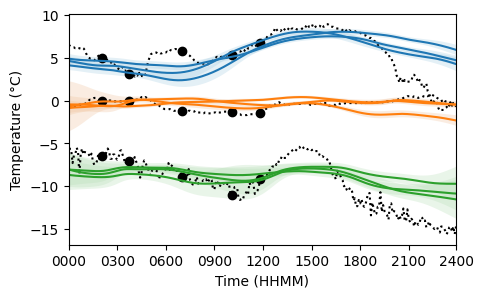

 72%|███████▏  | 7247/10000 [02:33<00:43, 62.64it/s]

iter 7250: avg. Train Loss = 249.78749438476564


 73%|███████▎  | 7261/10000 [02:35<02:43, 16.74it/s]

iter 7250: Val. Loss (NLL): 1032.9578800201416


 75%|███████▍  | 7497/10000 [02:39<00:40, 61.94it/s]

iter 7500: avg. Train Loss = 257.71177069091794


 75%|███████▌  | 7511/10000 [02:40<02:29, 16.69it/s]

iter 7500: Val. Loss (NLL): 835.8052206039429


 77%|███████▋  | 7747/10000 [02:44<00:34, 65.53it/s]

iter 7750: avg. Train Loss = 248.61829156494142


 78%|███████▊  | 7761/10000 [02:46<02:10, 17.10it/s]

iter 7750: Val. Loss (NLL): 1156.1582055091858


 80%|███████▉  | 7994/10000 [02:49<00:29, 68.34it/s]

iter 8000: avg. Train Loss = 236.03160803222656
iter 8000: Val. Loss (NLL): 1216.6015405654907


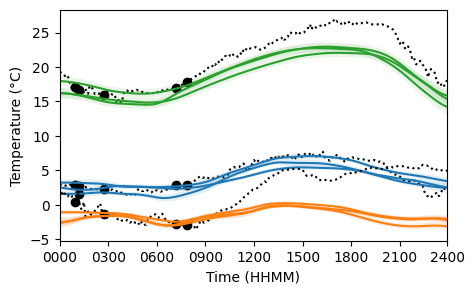

 82%|████████▏ | 8246/10000 [02:54<00:28, 62.44it/s]

iter 8250: avg. Train Loss = 233.58366583251953


 83%|████████▎ | 8260/10000 [02:56<01:44, 16.68it/s]

iter 8250: Val. Loss (NLL): 1009.4827942848206


 85%|████████▍ | 8498/10000 [03:00<00:24, 62.23it/s]

iter 8500: avg. Train Loss = 225.87468859863282


 85%|████████▌ | 8512/10000 [03:02<01:29, 16.67it/s]

iter 8500: Val. Loss (NLL): 1194.5529236793518


 87%|████████▋ | 8745/10000 [03:05<00:20, 62.01it/s]

iter 8750: avg. Train Loss = 221.6815679321289


 88%|████████▊ | 8759/10000 [03:07<01:14, 16.66it/s]

iter 8750: Val. Loss (NLL): 1484.692889213562


 90%|████████▉ | 8997/10000 [03:11<00:14, 71.64it/s]

iter 9000: avg. Train Loss = 213.43576025390624
iter 9000: Val. Loss (NLL): 1243.6659998893738


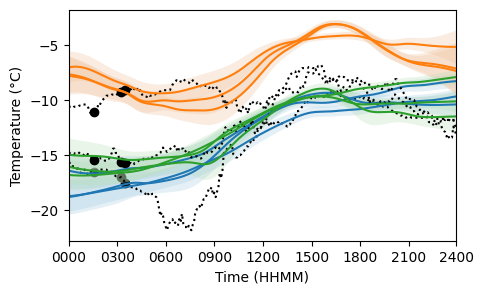

 92%|█████████▏| 9245/10000 [03:16<00:12, 62.38it/s]

iter 9250: avg. Train Loss = 203.1831796875


 93%|█████████▎| 9259/10000 [03:18<00:44, 16.73it/s]

iter 9250: Val. Loss (NLL): 1281.045581817627


 95%|█████████▍| 9497/10000 [03:22<00:08, 62.54it/s]

iter 9500: avg. Train Loss = 191.76881481933594


 95%|█████████▌| 9511/10000 [03:23<00:29, 16.73it/s]

iter 9500: Val. Loss (NLL): 1482.710473537445


 97%|█████████▋| 9749/10000 [03:27<00:04, 62.49it/s]

iter 9750: avg. Train Loss = 187.7531010131836


 98%|█████████▊| 9756/10000 [03:29<00:19, 12.72it/s]

iter 9750: Val. Loss (NLL): 1522.4066729545593


100%|█████████▉| 9994/10000 [03:33<00:00, 61.51it/s]

iter 10000: avg. Train Loss = 185.0493786010742
iter 10000: Val. Loss (NLL): 1461.3940930366516


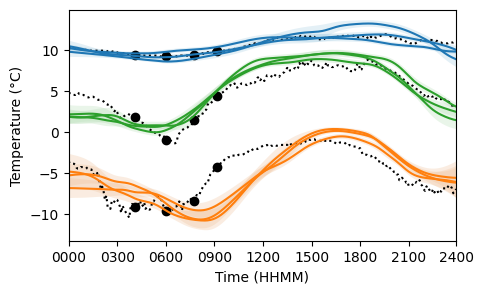

100%|██████████| 10000/10000 [03:34<00:00, 46.57it/s]


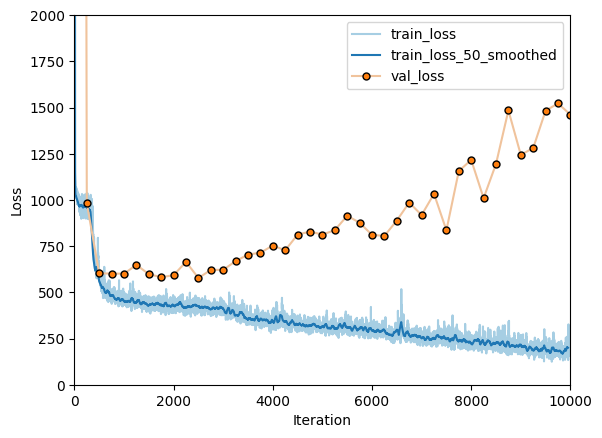

In [10]:
USE_KNOWLEDGE = False
logging.info(f'USE_KNOWLEDGE: {USE_KNOWLEDGE}')#

np_model = InformedNeuralProcess(
    **args,
    use_knowledge=USE_KNOWLEDGE
).to(DEVICE)

logging.info(np_model)
logging.info(f'Number of model parameters: {sum(p.numel() for p in np_model.parameters() if p.requires_grad)}')

logging.info(f'Using optimiser Adam')
loss_function = ELBOLoss(beta=1, reduction='mean')

np_optimiser = torch.optim.Adam(np_model.parameters(), lr=LEARNING_RATE)

np_model, best_nok_model_path, optimiser, train_losses, val_losses = train(model=np_model,
                                                   data=data,
                                                   loss_function=loss_function,
                                                   optimiser=np_optimiser,
                                                   device=DEVICE,
                                                   use_knowledge=USE_KNOWLEDGE,
                                                   max_iters=MAX_ITERS,
                                                   avg_loss_print_interval=AVG_LOSS_PRINT_INTERVAL,
                                                   plot_sample_interval=PLOT_SAMPLE_INTERVAL,
                                                   model_save_name="NP")

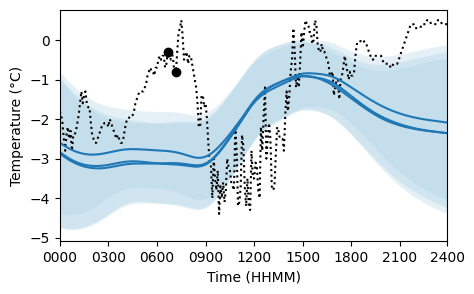

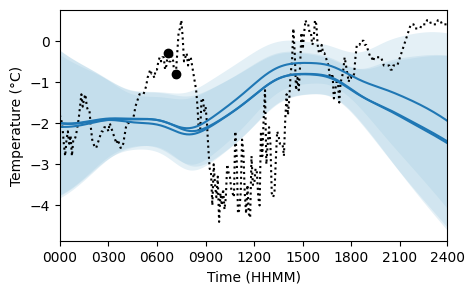

In [30]:
model.load_state_dict(torch.load(best_model_path))
nok_model.load_state_dict(torch.load(best_nok_model_path))

batch = data.generate_batch(batch_size=1,
                            device=DEVICE,
                            split='test',
                            return_knowledge=True,
                           num_context=2)
plot_predictive(model, batch)
plot_predictive(nok_model, batch)
# print(batch.knowledge)
# no = 3
# plot_predictive(model, batch, save=True, save_name=f"../figures/INP_trained_sample{no}")
# plot_predictive(no_knowledge_model, batch, save=True, save_name=f"../figures/NP_trained_sample{no}")

In [33]:
def eval(model, data, num_context=None):
    model.training = False
    with torch.no_grad():
        test_loss = 0
        n_test_batches = 1280
        test_batch_size = 96
        for _ in range(n_test_batches):
            batch = data.generate_batch(batch_size=test_batch_size,
                                    device=DEVICE,
                                    return_knowledge=False,
                                    split='test',
                                    num_context=num_context)
            
            p_y_pred, q_z_context, q_z_target = model(batch.x_context,
                                                  batch.y_context,
                                                  batch.x_target,
                                                  batch.y_target,
                                                  batch.knowledge)
            test_loss_dict = loss_function(p_y_pred, q_z_context, None, batch.y_target)
            test_loss += test_loss_dict["loss"].item() / n_test_batches
        # val_losses.append(val_loss)
        
    model.training = True
    return test_loss
num_contexts = np.arange(0, 10)
for num_context in range(1, 11):
    print(num_context)
    print(f"INP Test loss {eval(model, data, num_context)}")
    print(f"NP Test loss {eval(nok_model, data, num_context)}")
    print()

1
INP Test loss 1236.7816482067126
NP Test loss 1442.237318134304

2
INP Test loss 861.8272625207909
NP Test loss 871.5702321529408

3
INP Test loss 712.6510712146755
NP Test loss 677.3261328220369

4
INP Test loss 644.9760236978535
NP Test loss 601.3951287984853

5
INP Test loss 588.1860670328149
NP Test loss 554.9466562509541

6
INP Test loss 560.3447711467741
NP Test loss 524.7790258169181

7
INP Test loss 539.836348509788
NP Test loss 504.7191806554798

8
INP Test loss 523.741665124893
NP Test loss 493.23745243549416

9
INP Test loss 515.3559085845947
NP Test loss 478.2826607227333

10
INP Test loss 507.27400960922284
NP Test loss 471.2659355401991



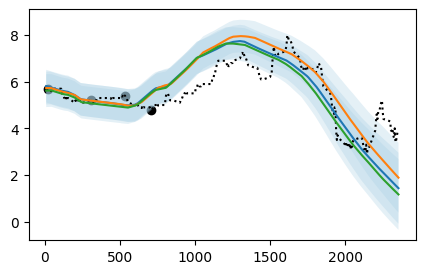

In [28]:
model.training = False
batch = data.generate_batch(batch_size=1, training=False, device=model.device)
plot_predictive(model, batch, knowledge=None, save=False, iter=None)
model.training = True


In [16]:
import transformers
from transformers import RobertaModel, RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)
langmodel = RobertaModel.from_pretrained("roberta-base")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
langmodel.to(device)
# freeze everything
for name, param in langmodel.named_parameters():
    if "LayerNorm" in name or name == 'pooler.dense.bias' or name == 'pooler.dense.weight':
        param.requires_grad = True
    else:
        param.requires_grad = False

#verify
for name, param in langmodel.named_parameters():
    print(name,param.requires_grad)

[DEBUG]: Starting new HTTPS connection (1): huggingface.co:443  ([2024-07-19 08:54:44] connectionpool.py:1051)
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/tokenizer_config.json HTTP/11" 200 0  ([2024-07-19 08:54:44] connectionpool.py:546)
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0  ([2024-07-19 08:54:44] connectionpool.py:546)
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0  ([2024-07-19 08:54:44] connectionpool.py:546)


KeyboardInterrupt: 

In [13]:
from src.plot import plot_predictive
from src.np import NeuralProcess

x_dim = 1
y_dim = 1
determ_dim = 128  # Dimension of representation of context points
latent_dim = 128  # Dimension of sampled latent variable
hidden_dim = 128  # Dimension of hidden layers in encoder and decoder

# np = NeuralProcess(x_dim=x_dim,
#                    y_dim=y_dim,
#                    hidden_dim=hidden_dim,
#                    latent_dim=latent_dim,
#                    determ_dim=determ_dim,
#                    knowledge_dim=768,
#                    n_h_layers_decoder=3,
#                    n_h_layers_phi_latent_encoder=2,
#                    n_h_layers_rho_latent_encoder=1,
#                    n_h_layers_phi_determ_encoder=6,
#                    n_h_layers_rho_determ_encoder=0,
#                    use_deterministic_path=False,
#                    )

model = NeuralProcess(x_dim=x_dim,
                   y_dim=y_dim,
                   hidden_dim=hidden_dim,
                   latent_dim=latent_dim,
                   determ_dim=determ_dim,
                   n_h_layers_decoder=4,
                   n_h_layers_phi_latent_encoder=2,
                   n_h_layers_rho_latent_encoder=1,
                   n_h_layers_phi_determ_encoder=5,
                   n_h_layers_rho_determ_encoder=0,
                   use_deterministic_path=True,
                   use_latent_self_attn=True,
                   use_determ_self_attn=False,
                   use_determ_cross_attn=True,
                   use_knowledge=True,
                   use_linear_knowledge_encoder=True,
                   knowledge_aggregation_method='FiLM+MLP',
                   knowledge_dim=768
                   )
print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

#data = SineData(max_num_context=30, random_kernel_parameters=True)
optimiser = torch.optim.Adam(model.parameters(), lr=5e-4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
model.to(device)

def preprocess_knowledge(knowledge_pre, langmodel, tokenizer):
    tokens = tokenizer.batch_encode_plus(
                        list(knowledge_pre),
                        add_special_tokens=True,
                        max_length=110,
                        padding='max_length',
                        return_token_type_ids=True
                    )
    input_ids = torch.tensor(tokens['input_ids']).to(device)
    attention_mask = torch.tensor(tokens['attention_mask']).to(device)
    token_type_ids = torch.tensor(tokens['token_type_ids']).to(device)
    lang_output = langmodel(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    knowledge_post = lang_output.pooler_output.unsqueeze(1)
    return knowledge_post

data_path = '../data/data_with_desc.csv'
data = pd.read_csv(data_path, header=None)
data = TempData(data=data , max_num_context=10, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
train_loss = []
avg_loss_fast = 0
avg_loss_slow = 0
for iter in tqdm(range(100000+1), mininterval=10):
    model.training = True
    optimiser.zero_grad()

    batch, knowledge_pre = data.generate_batch(batch_size=64, device=device, return_knowledge=True)
    # print(knowledge)
    knowledge = preprocess_knowledge(knowledge_pre, langmodel, tokenizer)

    zero_prob = 0.3
    mask = torch.rand((64, 1, 1), device=device) > 0.3
    knowledge = knowledge * mask
    # print(knowledge)
    # break
    
    p_y_pred, loss, log_lik = model(batch.x_context, batch.y_context, batch.x_target, knowledge, batch.y_target)
    # print(loss.item())
    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    avg_loss_slow += loss.item()
    avg_loss_fast += loss.item()

    if iter % 1000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss = {avg_loss_fast/1000}")
        #print(f"iter. loss = {loss.item()}, iter. Loss2 (not being backpropped on) = {loss2.item()}")
        avg_loss_fast = 0
    if iter % 10000 == 0:
        print(f"iter {iter+1}: Avg. Loss SLOW = {avg_loss_slow/1000}")
        avg_loss_slow = 0
        
        with torch.no_grad():
            val_loss = 0
            n_val_batches = 32
            val_batch_size = 64
            for _ in range(n_val_batches):
                batch, knowledge_pre = data.generate_batch(batch_size=val_batch_size, training=False, device=model.device, return_knowledge=True)
                knowledge = preprocess_knowledge(knowledge_pre, langmodel, tokenizer)
                
                p_y_pred, _loss, log_lik = model(batch.x_context, batch.y_context, batch.x_target, knowledge, batch.y_target)
                val_loss += _loss
            print(f"Val Loss: {val_loss / n_val_batches}")
        
    # if iter % 20000 == 0:
        model.training = False
        batch, knowledge_pre = data.generate_batch(batch_size=1, device=model.device, training=False, return_knowledge=True)
        knowledge = preprocess_knowledge(knowledge_pre, langmodel, tokenizer)
        plot_predictive(model, batch, knowledge=knowledge, save=False, iter=None)
        model.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()
device = 'cuda' if torch.cuda.is_available() else 'cpu'


ModuleNotFoundError: No module named 'src.np'

In [7]:
# torch.save(np.state_dict(), f'../exp/{"inp_roberta_test1.pt"}')
model.load_state_dict(torch.load(f'../exp/{"inp_roberta_test1.pt"}'))

<All keys matched successfully>

In [52]:
model.training = False
batch, knowledge_pre = data.generate_batch(batch_size=1, device=model.device, return_knowledge=True)
print(knowledge_pre)

['The night will start off cold with temperatures falling to -5.3°C by early morning, but it will gradually warm up reaching 6.2°C in the late afternoon, before cooling down again to -2.0°C at midnight.']


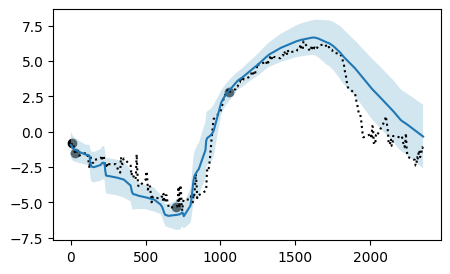

In [56]:
# knowledge_pre = ['The night will be bitterly cold with temperatures falling to -16.4°C, gradually rising to -13.4°C by early morning, and remarkably, the afternoon will see a significant temperature shift, hovering around freezing point at 0.3°C.']
knowledge_pre = ['The night will start off cold with temperatures falling to -5.3°C by early morning, but it will gradually warm up reaching 20°C in the late afternoon, before cooling down again to -2.0°C at midnight.']

model.training = False
knowledge = preprocess_knowledge(knowledge_pre, langmodel, tokenizer)
plot_predictive(model, batch, knowledge=knowledge, save=False, iter=None)

model.training = True
